In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import sys
import os
import math

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_6492\931607244.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Input Embedding



In [52]:
# Use embedding from scratch "Embedding is learnable through training"
# or use word2vec pretrained model
# word2vec will give better results!

class InputEmbedding(nn.Module):
    
    def __init__(self, d_model: int = 512, vocab_length: int = 1024):
        super().__init__()
        self.d_model        = d_model
        self.vocab_sequence = vocab_length
        self.embedding      = nn.Embedding(
            num_embeddings  = vocab_length, 
            embedding_dim   = d_model
            )
     
    def forward(self, x):
        # scaling the embedding vectors by multiplying them with the square root of d_model. Why? 
        # to maintain the variance of the embeddings when they are passed through the network
        # To stabilize the gradients during training. 
        # It helps to prevent the gradients from becoming too small or too large, 
        # which can lead to issues like vanishing or exploding gradients.
        
        # (batch, seq_len) --> (batch, seq_len, d_model)
        return self.embedding(x) *math.sqrt(self.d_model)

# Positional Encoding
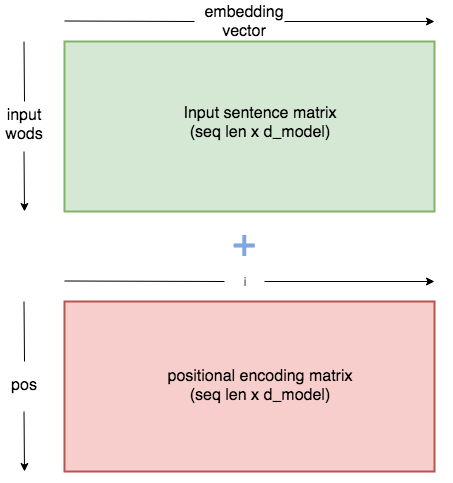

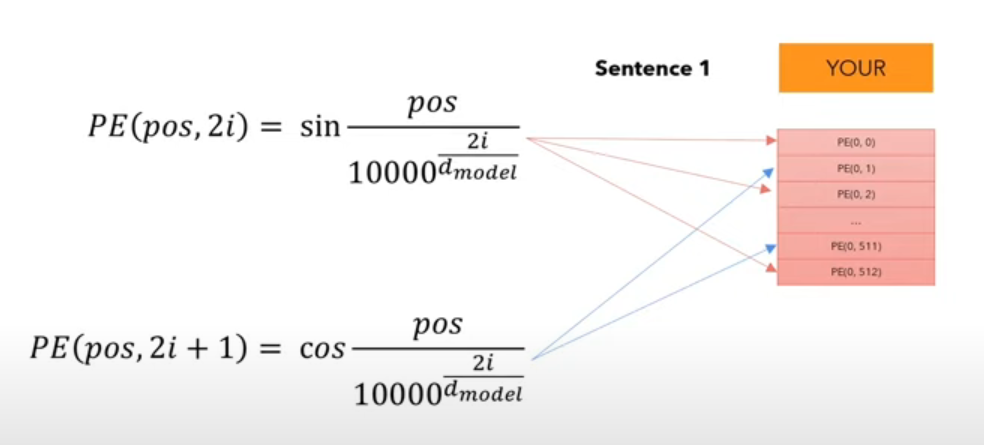

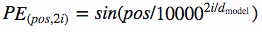



pos -> refers to order in the sentence

i -> refers to position along embedding vector dimension

In [53]:
# we use positional encoding because the attention mechanisms are position invariant
# it gives our model a way to understand where each word or token is in a sequence.

class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int = 512, sequence_len: int = 20, dropout: float = 0.3):
        super().__init__()
        self.d_model        = d_model
        self.sequence_len   = sequence_len
        self.dropout        = nn.Dropout(dropout) 
        
        # batch size of 32 
        # seq length of 10 
        # embedding dimension be 512. 
        # Then we will have embedding vector of dimension 32 x 10 x 512
        
        # pe shape(sequence_length x d_model)
        pe = torch.zeros(self.sequence_len, self.d_model)
        
        # NUMERATOR: position vector shape(sequence_len -> sequence_len x 1)
        # For each token(word) in sequence, we will find the embedding vector which is of dimension 1 x 512 
        # and it is added with the correspondng positional vector which is of dimension 1 x 512 
        # to get 1 x 512 dim out for each word/token.
        position = torch.arange(start=0, end=sequence_len, dtype=torch.float).unsqueeze(1)
        
        # Denomenator: div_term of the formula shape(d_model)
        # calculation is done in log space for numerical stability
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * (-math.log(10000.0) / d_model))
        # arange = 2i 
        
        # Apply sine and cosine. The sine is applied to even numbers; cosine to odd numbers
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, sequence_len, d_model)
        
        # Tensor that I want to keep in the model
        # Not as a parameter
        # I want it to be saved when I saved the state of the model 
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # We slice it to match the dimensions of the word embedding
        # We take dim 1 (pos_embeddings) and align them with the dim 1 of x (actual word embeddings)
        # x.shape       = [batch_size=2,sequence_length=5,         embedding_dim=512]
        # self.pe.shape = [             max_sequence_length=1000,  embedding_dim=512]
        # self.pe[:, :x.shape[1]]  # Extracts the first 5 positional encodings
        # take the needed number of sequences instead of all sequences
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        # x = x + (self.pe[:, :x.shape[1]]).requires_grad(False)
        return self.dropout(x)


# Layer Normalization
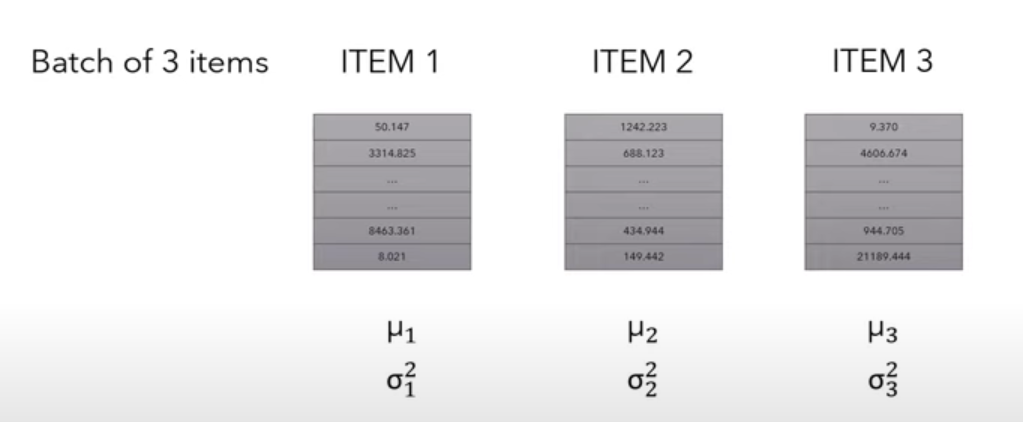

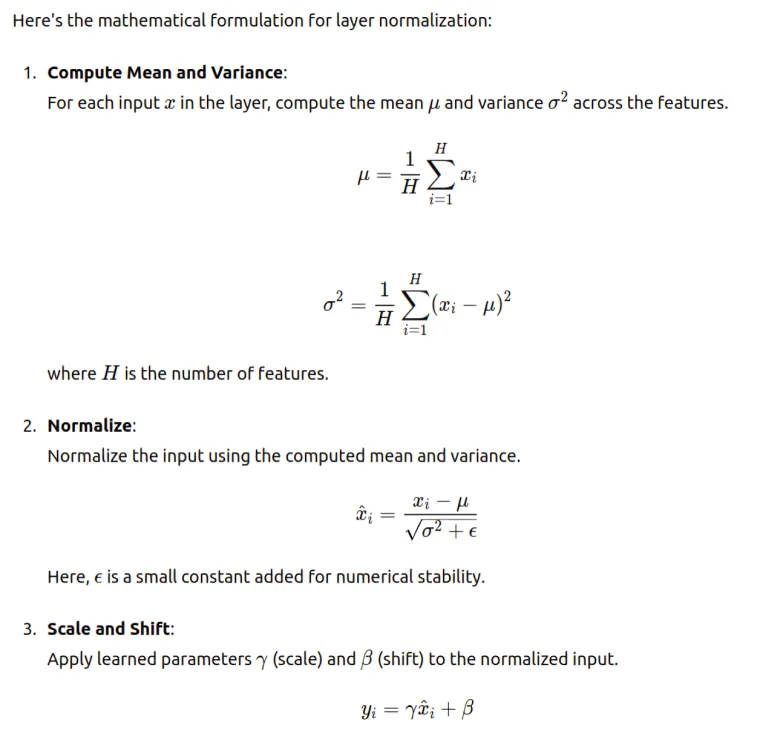

In [54]:
class LayerNormalization(nn.Module):
    
    def __init__(self, d_model: int = 512, eps: float = 10**-6):
        super().__init__()
        
        # eps in the denominator to avoid dividing by zero if sigma is zero
        self.eps    = eps
        # Gamma (γ): This is a learnable scale parameter. 
        # After normalization, the data is centered around zero with unit variance. 
        # The gamma parameter allows the model to scale the normalized data.
        self.gamma  = nn.Parameter(torch.ones(d_model)) # Multiplied #(nn.Parameter makes them learnable)
        #Beta (β): This is a learnable shift parameter. 
        # After scaling the data with gamma, the beta parameter allows the model to shift the normalized data.
        self.bias   = nn.Parameter(torch.zeros(d_model)) # added # (nn.Parameter makes them learnable)
        
    def forward(self,x):
        # x = (batch_size,seq_len ,d_model)
                 # Keep the dimension for broadcasting

        # mean of the last dimension "everything after the batch"
        # keepdim => mean cancels the dimension which is applied to but we want to keep it!
        # dim=-1: This ensures the normalization is done across the feature dimension d_model
        # keepdim=True: Ensures the reduced dimension is retained, 
        # allowing the mean and standard deviation to be broadcast correctly for normalization.
        mean    = x.mean(dim = -1, keepdim=True) # (batch, seq_len, 1)
        std     = x.std(dim = -1, keepdim=True)  # (batch, seq_len, 1)
        
        # Gamma is multiplicative and Beta is additive
        return self.gamma * (x - mean) / (std + self.eps) + self.bias
        

# Residual Connection

In [55]:
class ResidualConnection(nn.Module):
    
    def __init__(self, d_model: int, dropout: float):
        super().__init__()
        
        self.dropout    = nn.Dropout(dropout)
        self.norm       = LayerNormalization(d_model)
        
    #  “skip” one or more layers, 
    # directly connecting the input of a layer 
    # to the output of another layer further down the stack
    
    # This helps mitigate the problem of vanishing gradients and 
    # allows for more effective training of very deep networks.
    def forward(self, x, prev_layer):
        x_norm = self.norm(x)
        # sublayer (e.g., attention or feed-forward block)
        x_prev_layer = prev_layer(x_norm) 
        x = x + self.dropout(x_prev_layer)
        
        return x

# FFN

In [56]:
class FeedForward(nn.Module):
    
    def __init__(self, d_model: int = 512, d_ff: int = 2048, dropout: float = 0.3):
        super().__init__()
        
        self.linear1    = nn.Linear(d_model, d_ff) #w1, b1
        self.dropout    = nn.Dropout(dropout)
        self.linear2    = nn.Linear(d_ff, d_model) #w2, b2
        
    def forward(self, x):
        x   = self.linear1(x)
        x   = F.relu(x)
        x   = self.dropout(x)
        x   = self.linear2(x)
        
        return x

# Mask

In [57]:
def create_mask(seq_len):
    """
    Creates a seq_len * seq_len lower triangular mask for self-attention.
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

# # Example usage:
# seq_len = 5
# masked = create_mask(seq_len)
# masked = masked.masked_fill(masked, float('-inf'))
# print(masked)


# Self-Attention & Multi-head Attention
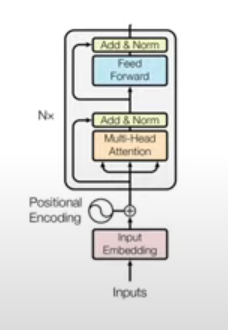

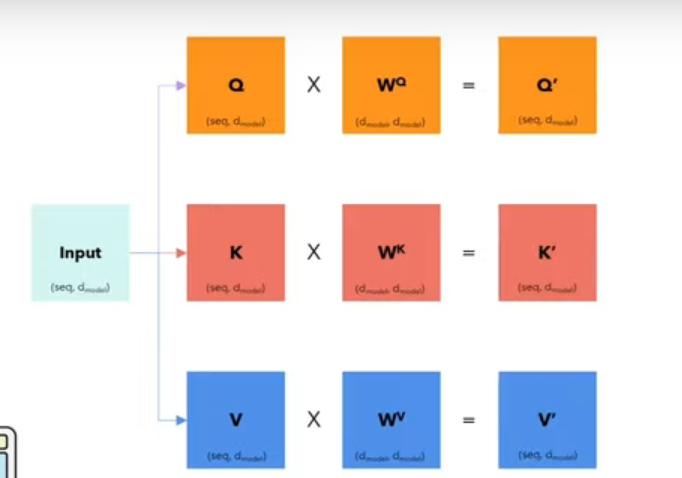

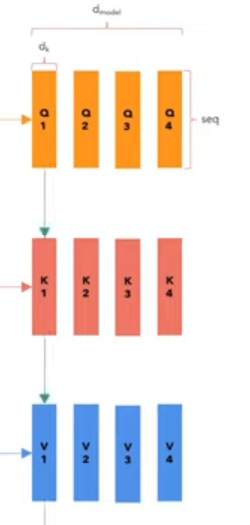

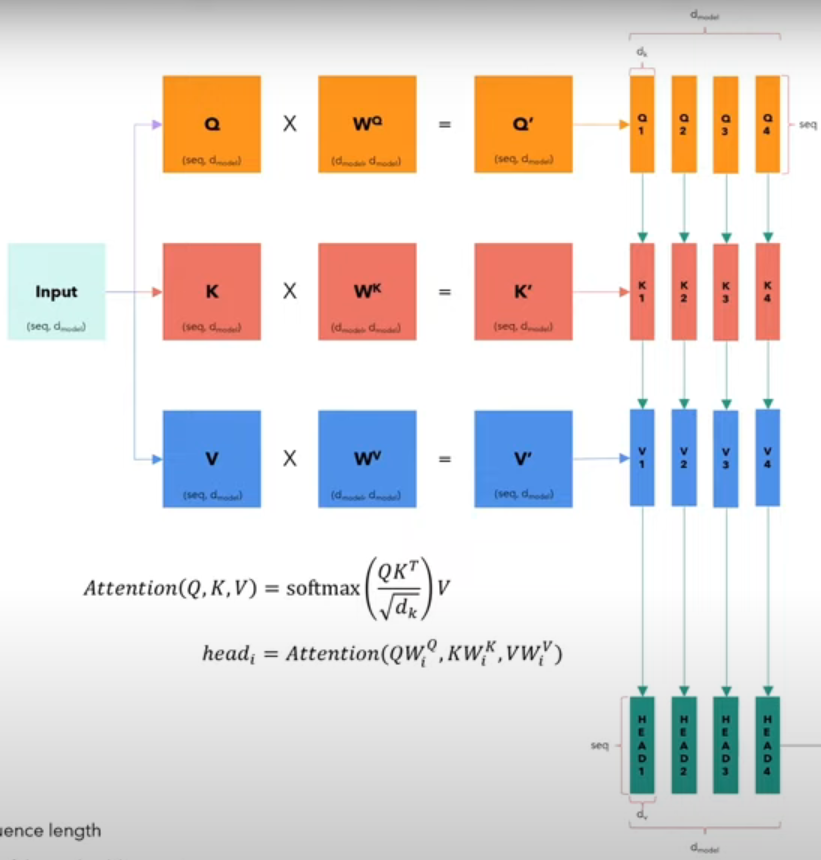

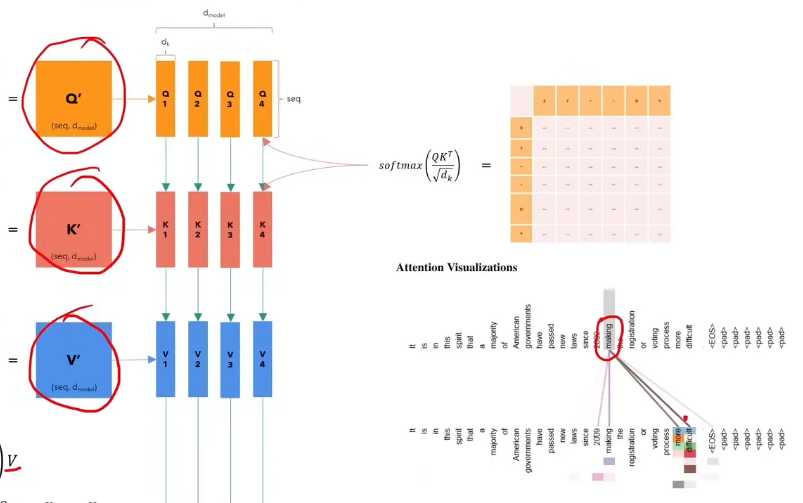

In [58]:
class SelfAttention(nn.Module):
    def __init__(self, d_k, dropout: nn.Dropout):
        super().__init__()
        
        self.d_k        = d_k
        self.dropout    = dropout
        
    def forward(self, q_bar, k_bar, v_bar, mask):
        
        # Transform: [Batch, n_heads, seq_len, d_k] -> [Batch, n_heads, seq_len, seq_len]
        # keep batches
        # keep n_heads
        # transpose last 2 dimensions k[_,_,seq_len, d_k].transpose()
        #q[seq_len,d_k] * k[d_k,seq_len] => [seq_len, seq_len]
        attention_math             = ( (q_bar @ k_bar.transpose(-2,-1)) / math.sqrt(self.d_k) )
        
        # mask
        if mask:
            # [seq_len, seq_len]
            # self.attention_masked       = self.attention_math + mask
            # replaces values in the attention scores with -inf where the mask is True.
            attention_masked       = attention_math.masked_fill(mask, -1e9)
            attention_probabilities    =   F.softmax(attention_masked, dim=-1)
        else:
        # softmax
        # [seq_len, seq_len]
            attention_probabilities    =   F.softmax(attention_math, dim=-1)
            # self.attention_probabilities    =   self.attention_math.softmax(dim=-1)
            
        # dropout
        if self.dropout:
            attention_score        = self.dropout(attention_probabilities)
        else:
            attention_score        = attention_probabilities
            
                # self-attention     # attention-score
        self_attention = attention_score @ v_bar    # return (attention_prop @ v), attention_prop
        return self_attention, attention_score


# Multi-Head Attention
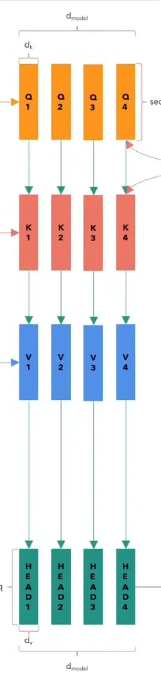

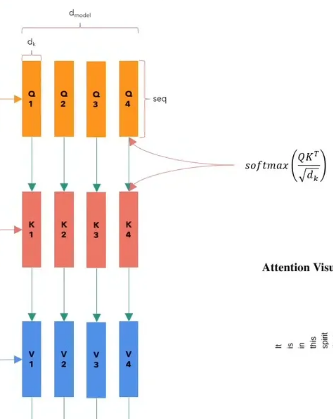

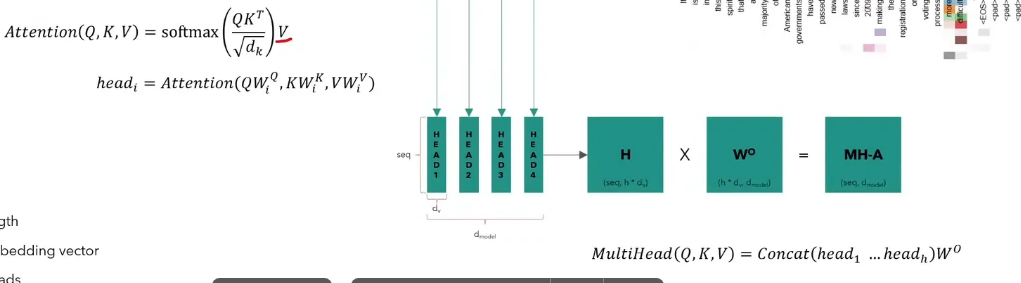

In [59]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model: int = 512, heads: int = 8, dropout: float = 0.3):
        super().__init__()
        
        self.d_model    = d_model
        self.heads      = heads
        # make sure d_model is divisible by h
        assert self.d_model % self.heads  == 0, "d_model is not divisible by head "
        
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # dimension of vector seen by each head
        # d_k is the dim that each tensor will be parallelized to in different heads
        self.d_k = d_model // heads
        
    # @staticmethod
    # q,k,v are here coming here after being multiplied by w 
    # and after being divided by d_k
        
    def forward(self, q, k, v, mask):
        # matrix multiplication for q * wq
        q_bar   = self.wq(q)
        # matrix multiplication for k * wk
        k_bar   = self.wk(k)
        # matrix multiplication for v * wv
        v_bar   = self.wv(v)
        
        # 1) divide into (d_model) into (heads x d_k) "3D" => '4D'
        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) 
        q_bar   = q_bar.view(q_bar.shape[0], q_bar.shape[1], self.heads, self.d_k)
        k_bar   = k_bar.view(k_bar.shape[0], k_bar.shape[1], self.heads, self.d_k)
        v_bar   = v_bar.view(v_bar.shape[0], v_bar.shape[1], self.heads, self.d_k)
        
        # 2) transpose
        # (batch, seq_len, h, d_k).transpose --> (batch, h, seq_len, d_k)
        q_bar   = q_bar.transpose(1,2)
        k_bar   = k_bar.transpose(1,2)
        v_bar   = v_bar.transpose(1,2)
        
        if mask:
            # Expand mask for batch size and number of heads
            mask = mask.unsqueeze(0).unsqueeze(1)

        # calculate attention
        attention = SelfAttention(self.d_k, self.dropout)
        self_attention, attention_score = attention(q_bar,k_bar,v_bar, mask)
        
        # combine all heads together
        # 1) transpose
        # (batch, h, seq_len, d_k).transpose --> (batch, seq_len, h, d_k) 
        self_attention = self_attention.transpose(1,2).contiguous()

        # 2) combine heads together
        # (batch, seq_len, h, d_k)  --> (batch, seq_len, d_model)
        self_attention = self_attention.view(
                                            self_attention.shape[0], 
                                            self_attention.shape[1],
                                            self.heads*self.d_k
                                            )
        
        # matrix multiplication for self_attention "head concatenated" * wo
        return self.wo(self_attention)
        

# Encoder
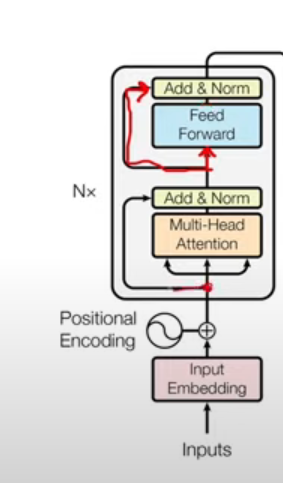

In [60]:
class Encoder(nn.Module):
    
    def __init__(self, mask = None, heads = 8, d_model = 512, d_ff = 2056, dropout = 0.3):
        super().__init__()
        
        self.dropout        = dropout
        self.mask           = mask
        self.multihead      = MultiHeadAttention(d_model, heads, dropout)
        self.norm_multihead = ResidualConnection(d_model, dropout)
        self.ffn            = FeedForward(d_model, d_ff, dropout)
        self.norm_ffn       = ResidualConnection(d_model, dropout)
        
    def forward(self, x):

        # multihead_out       = self.multihead( x, x, x, self.mask )
        # norm_multihead_out  = self.norm_multihead(x, multihead_out)
        norm_multihead_out  = self.norm_multihead(x, lambda x: self.multihead(x, x, x, self.mask))
        # ffn_out             = self.ffn(norm_multihead_out)
        norm_ffn_out        = self.norm_ffn(norm_multihead_out, lambda x:  self.ffn(x))
        # norm_ffn_out        = self.norm_ffn(norm_multihead_out, lambda x: self.ffn(x))
        
        return norm_ffn_out
        

# Stacked Encoder

In [61]:
class StackedEncoder(nn.Module):
    
    def __init__(self, mask = None, src_vocab_len = 2056, sequence_len=20, num_layers = 6, heads = 8, 
                 d_model = 512, d_ff = 1024, dropout = 0.3):
        super().__init__()
        
        # class InputEmbedding(nn.Module):
        #     def __init__(self, d_model: int = 512, vocab_length: int = 1024):
        # class PositionalEncoding(nn.Module):
        #     def __init__(self, d_model: int = 512, sequence_len: int = 20, dropout: float = 0.3):

    
        self.d_model        = d_model
        self.input_embed    = InputEmbedding(d_model, src_vocab_len)
        self.pos_encod      = PositionalEncoding(d_model, sequence_len, dropout)
        
        self.encoder_stack  = nn.Sequential() #is used when you want to run certain layers sequentially.
        for i in range(num_layers):
            self.encoder_stack.add_module("Encoder_Layer_"+str(i), Encoder(mask, heads, d_model, d_ff, dropout))
            
        
    def forward(self, x):
        
        embedding       = self.input_embed(x)
        pos_encod       = self.pos_encod(embedding)
        encoded_out     = self.encoder_stack(pos_encod)
        
        return encoded_out
        
        

In [62]:
# Test the StackedEncoder
if __name__ == "__main__":
    # Define the parameters for the test
    batch_size = 32   # Number of sequences in a batch
    seq_len = 20      # Length of each sequence
    vocab_size = 1000 # Size of the vocabulary
    d_model = 512     # Embedding dimension
    num_layers = 6    # Number of encoder layers
    heads = 8         # Number of attention heads
    d_ff = 1024       # Feedforward network size
    dropout = 0.3     # Dropout rate

    # Create random input (batch_size, seq_len) with random token indices
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))
    print(f"input shape: {dummy_input.shape}")

    # Initialize the StackedEncoder
    stacked_encoder = StackedEncoder(src_vocab_len=vocab_size, sequence_len=seq_len, num_layers=num_layers, heads=heads, d_model=d_model, d_ff=d_ff, dropout=dropout)

    # Forward pass through the StackedEncoder
    output = stacked_encoder(dummy_input)

    # Print output shape to verify
    print(f"Output shape: {output.shape}")


input shape: torch.Size([32, 20])
Output shape: torch.Size([32, 20, 512])
